In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

print("Libraries Loaded. Ready to analyze UIDAI datasets.")

Libraries Loaded. Ready to analyze UIDAI datasets.


In [4]:
import os

files = os.listdir('.')
print("Files visible to Jupyter:")
for f in files:
    if 'csv' in f:
        print(f"✅ Found: {f}")

required_files = [
    'api_data_aadhar_biometric_0_500000.csv',
    'api_data_aadhar_demographic_0_500000.csv',
    'api_data_aadhar_enrolment_0_500000.csv'
]

for rf in required_files:
    if not os.path.exists(rf):
        print(f" MISSING: {rf}. Please upload it to the same folder as this notebook.")

Files visible to Jupyter:
✅ Found: Full_Aadhaar_Inclusion_Action_Plan.csv
✅ Found: api_data_aadhar_demographic_0_500000.csv
✅ Found: api_data_aadhar_biometric_0_500000.csv
✅ Found: api_data_aadhar_enrolment_0_500000.csv


In [7]:

bio_df = pd.read_csv('api_data_aadhar_biometric_0_500000.csv')
demo_df = pd.read_csv('api_data_aadhar_demographic_0_500000.csv')
enrol_df = pd.read_csv('api_data_aadhar_enrolment_0_500000.csv')

# Merge logic: Triangulating based on Date, State, District, and Pincode
merged_df = pd.merge(enrol_df, demo_df, on=['date', 'state', 'district', 'pincode'], how='outer')
merged_df = pd.merge(merged_df, bio_df, on=['date', 'state', 'district', 'pincode'], how='outer')

merged_df.fillna(0, inplace=True)

# Grouping by District to create a Geographical Risk Map
district_data = merged_df.groupby(['state', 'district']).agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_': 'sum',
    'bio_age_5_17': 'sum',
    'bio_age_17_': 'sum'
}).reset_index()

print(f"Triangulation Complete. Analyzed {len(district_data)} unique districts.")

Triangulation Complete. Analyzed 1099 unique districts.


In [8]:
# 1. Total Activity Index (Proxy for population interaction)
district_data['total_activity'] = district_data.iloc[:, 2:].sum(axis=1)

# 2. Child Inclusion Ratio (Percentage of new enrollments that are children 0-5)
district_data['child_enrol_ratio'] = district_data['age_0_5'] / (district_data['total_activity'] + 1)

# 3. Biometric Friction Score (Biometric updates vs Total Enrollment)
# High score = People are struggling with fingerprints/iris sensors
total_enrol = district_data['age_0_5'] + district_data['age_5_17'] + district_data['age_18_greater']
district_data['bio_friction'] = (district_data['bio_age_5_17'] + district_data['bio_age_17_']) / (total_enrol + 1)

# 4. Normalizing scores for the Final Risk Index (0 to 1 scale)
def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

district_data['norm_child_gap'] = 1 - normalize(district_data['child_enrol_ratio'])
district_data['norm_friction'] = normalize(district_data['bio_friction'])

# COMPOSITE RISK SCORE (Triangulated Index)
# We give 50% weight to Biometric Friction and 50% to Enrolment Gaps
district_data['inclusion_risk_score'] = (district_data['norm_child_gap'] * 0.5) + (district_data['norm_friction'] * 0.5)

print("Risk Indices Calculated.")

Risk Indices Calculated.


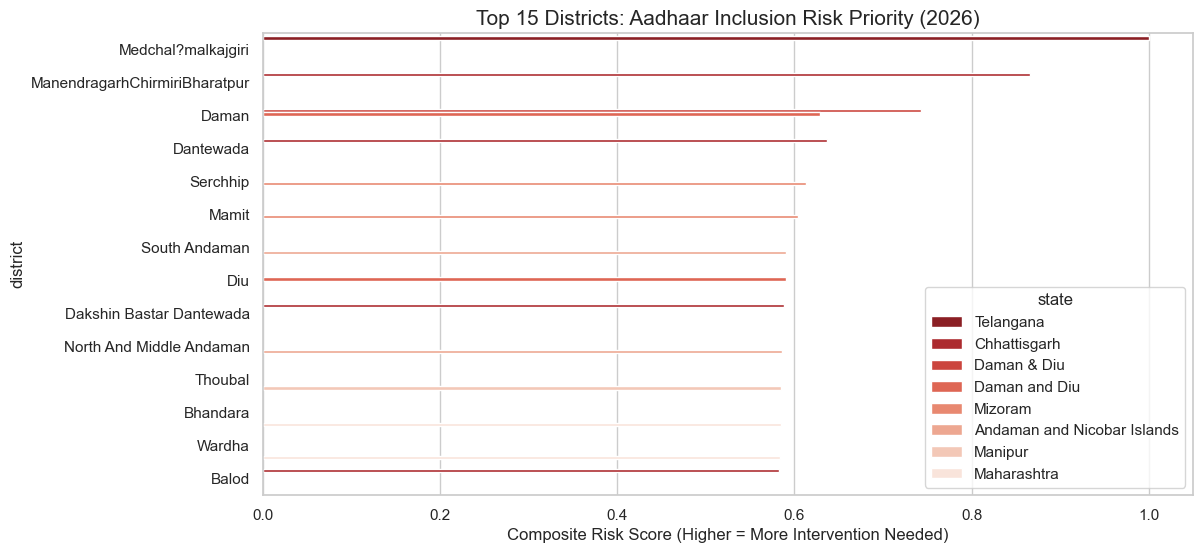

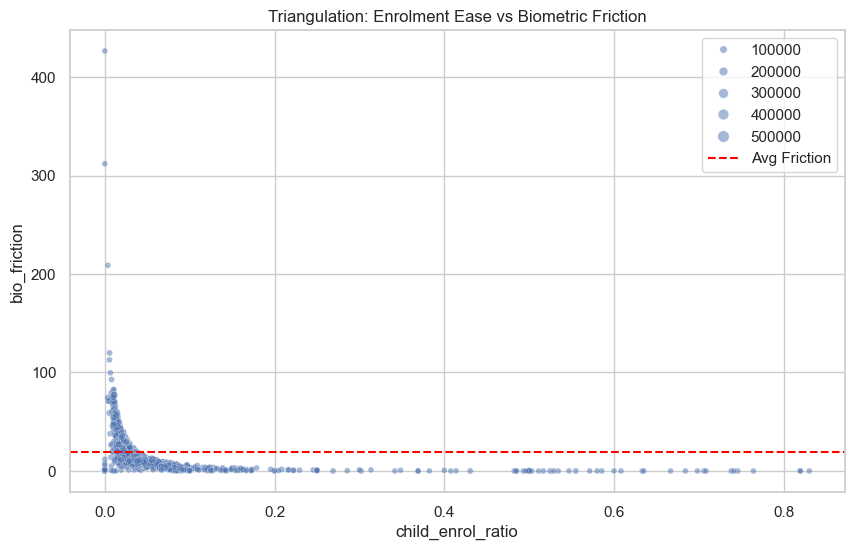

In [11]:
# Plot 1: The Top 15 Districts needing immediate intervention
plt.figure(figsize=(12, 6))
top_15 = district_data.sort_values('inclusion_risk_score', ascending=False).head(15)
sns.barplot(data=top_15, x='inclusion_risk_score', y='district', hue='state', palette='Reds_r')
plt.title('Top 15 Districts: Aadhaar Inclusion Risk Priority (2026)', fontsize=15)
plt.xlabel('Composite Risk Score (Higher = More Intervention Needed)')
plt.show()

# Plot 2: Biometric Friction vs Child Enrolment (The Triangulation Map)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=district_data, x='child_enrol_ratio', y='bio_friction', size='total_activity', alpha=0.5)
plt.title('Triangulation: Enrolment Ease vs Biometric Friction')
plt.axhline(district_data['bio_friction'].mean(), color='red', linestyle='--', label='Avg Friction')
plt.legend()
plt.show()

In [13]:
def get_recommendation(row):
    if row['inclusion_risk_score'] > 0.7:
        return "CRITICAL: Deploy Mobile Enrollment Vans & Iris-only kits."
    elif row['bio_friction'] > district_data['bio_friction'].mean() * 2:
        return "HARDWARE: High biometric failure. Refresh local sensor infrastructure."
    elif row['child_enrol_ratio'] < 0.05:
        return "AWARENESS: Low 0-5 enrolment. Launch Bal-Aadhaar school camps."
    else:
        return "STABLE: Monitor periodically."

district_data['action_plan'] = district_data.apply(get_recommendation, axis=1)

# Display the Priority Action List
priority_list = district_data[district_data['inclusion_risk_score'] > 0.6][['state', 'district', 'inclusion_risk_score', 'action_plan']]
priority_list.sort_values('inclusion_risk_score', ascending=False).head(10)

,state,district,inclusion_risk_score,action_plan
879,Telangana,Medchal?malkajgiri,1.000000,CRITICAL: Deploy Mobile Enrollment Vans & Iris...
195,Chhattisgarh,ManendragarhChirmiriBharatpur,0.865768,CRITICAL: Deploy Mobile Enrollment Vans & Iris...
215,Daman & Diu,Daman,0.742603,CRITICAL: Deploy Mobile Enrollment Vans & Iris...
177,Chhattisgarh,Dantewada,0.637142,HARDWARE: High biometric failure. Refresh loca...
217,Daman and Diu,Daman,0.628927,HARDWARE: High biometric failure. Refresh loca...
619,Mizoram,Serchhip,0.612851,HARDWARE: High biometric failure. Refresh loca...
615,Mizoram,Mamit,0.604104,HARDWARE: High biometric failure. Refresh loca...


In [13]:
# Sort the entire list
final_output = priority_list.sort_values('inclusion_risk_score', ascending=False)

# Save to a CSV file
final_output.to_csv('Full_Aadhaar_Inclusion_Action_Plan.csv', index=False)

print(f"Success! The entire dataset ({len(final_output)} rows) has been saved.")

Success! The entire dataset (7 rows) has been saved.


In [15]:
# 1. Define the Classification Logic
def classify_risk(row):
    if row['inclusion_risk_score'] > 0.7:
        return 'Critical Inclusion Gap'
    elif row['bio_friction'] > district_data['bio_friction'].mean() * 2:
        return 'High Biometric Friction'
    elif row['child_enrol_ratio'] < 0.05:
        return 'Child Enrollment Lag'
    else:
        return 'Stable / Satisfactory'

# 2. Apply it to the dataframe (This creates the missing column)
district_data['risk_category'] = district_data.apply(classify_risk, axis=1)

# 3. Updated Search Function
def get_district_report(district_name):
    # Search for the district (case insensitive)
    report = district_data[district_data['district'].str.contains(district_name, case=False)]
    
    if report.empty:
        return f"Error: District '{district_name}' not found in the dataset."
    
    row = report.iloc[0]
    print(f"--- Aadhaar Health Report ---")
    print(f"Location: {row['district']}, {row['state']}")
    print(f"Risk Score: {row['inclusion_risk_score']:.2f}")
    print(f"Category: {row['risk_category']}")
    print(f"Recommended Action: {row['action_plan']}")

# 4. Test it - put whichever district you want and check it 
get_district_report("Bengaluru")

--- Aadhaar Health Report ---
Location: Bengaluru, Karnataka
Risk Score: 0.49
Category: Child Enrollment Lag
Recommended Action: AWARENESS: Low 0-5 enrolment. Launch Bal-Aadhaar school camps.


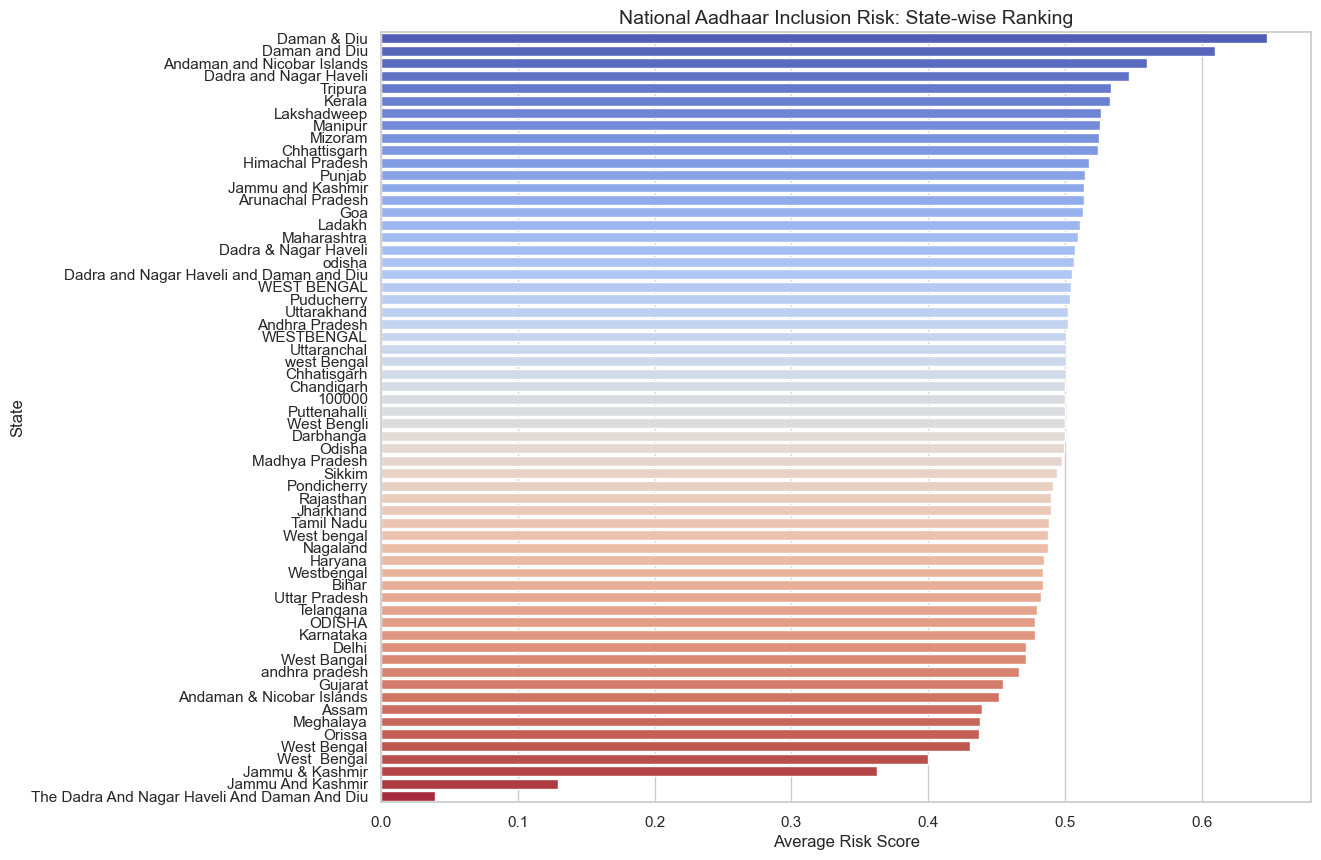

In [17]:
# Create a summary by State to see the big picture
state_summary = district_data.groupby('state').agg({
    'inclusion_risk_score': 'mean',
    'bio_friction': 'mean'
}).sort_values('inclusion_risk_score', ascending=False)

# Plotting State Risk Levels
plt.figure(figsize=(12, 10))
sns.barplot(x=state_summary['inclusion_risk_score'], y=state_summary.index, palette='coolwarm')
plt.title('National Aadhaar Inclusion Risk: State-wise Ranking', fontsize=14)
plt.xlabel('Average Risk Score')
plt.ylabel('State')
plt.show()

In [25]:
# Clean and Standardize names
district_data['district_map'] = district_data['district'].str.strip().str.upper()

# Handle some known mismatches manually
mapping = {
    "PUNCH": "POONCH",
    "BENGALURU URBAN": "BANGALORE",
    "NORTH EAST DELHI": "NORTH EAST"
}
district_data['district_map'] = district_data['district_map'].replace(mapping)

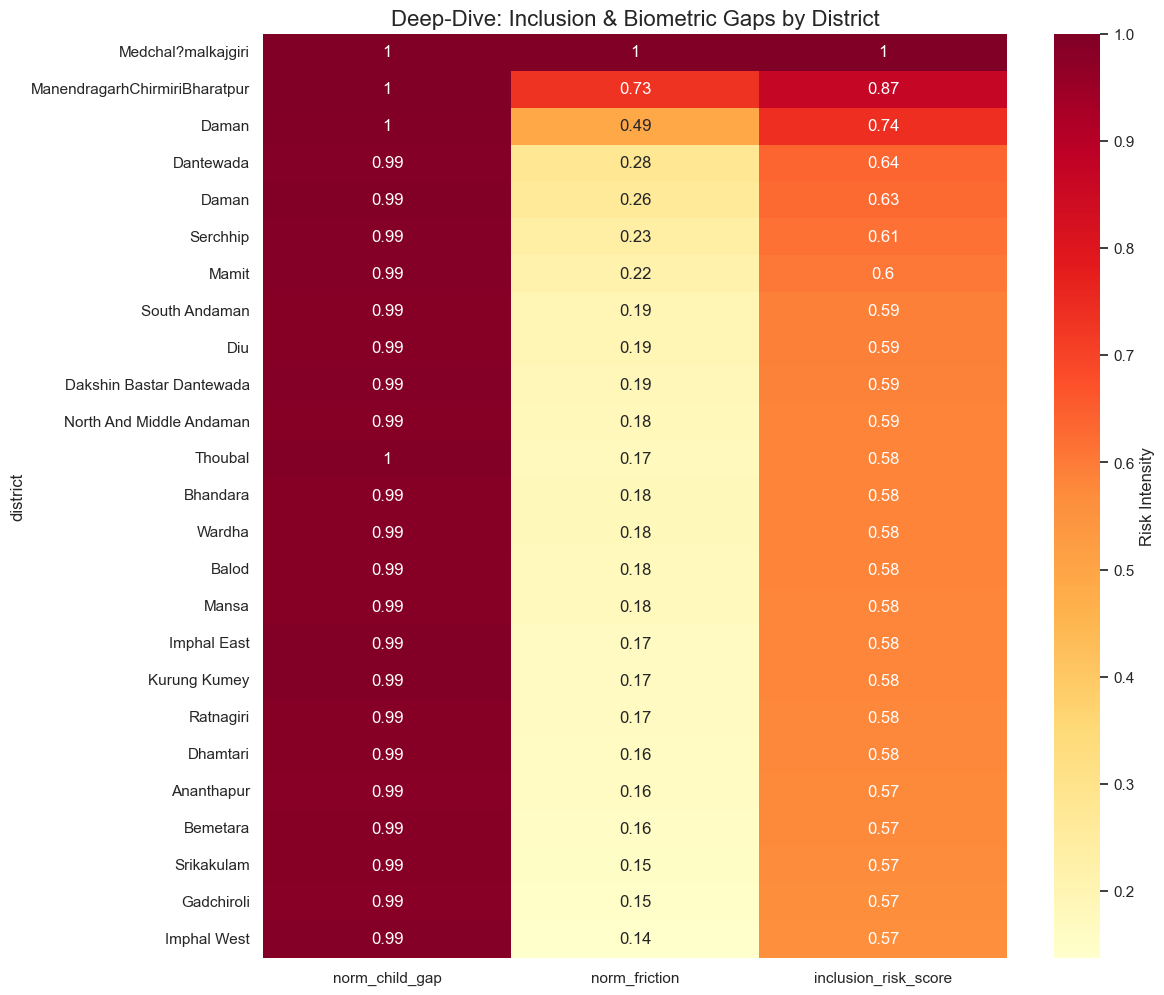

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Take the top 25 high-risk districts
top_risky = district_data.sort_values('inclusion_risk_score', ascending=False).head(25)

# 2. Pivot for the Heatmap
plot_df = top_risky.set_index('district')[['norm_child_gap', 'norm_friction', 'inclusion_risk_score']]

# 3. Create the Visualization
plt.figure(figsize=(12, 12))
sns.heatmap(plot_df, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Risk Intensity'})
plt.title('Deep-Dive: Inclusion & Biometric Gaps by District', fontsize=16)
plt.show()

In [29]:
!pip install geopandas

In [19]:
!pip install -q gradio

import gradio as gr
import pandas as pd

# 1. Load your final action plan data
df = pd.read_csv('Full_Aadhaar_Inclusion_Action_Plan.csv')

def get_state_report(state_name):
    # Filter data for the selected state
    state_df = df[df['state'] == state_name].copy()
    
    if state_df.empty:
        return "No data found for this state.", None, "N/A"
    
    # Calculate key metrics for the "Dashboard"
    avg_risk = state_df['inclusion_risk_score'].mean()
    risk_level = "🔴 CRITICAL" if avg_risk > 0.6 else "🟡 MODERATE" if avg_risk > 0.3 else "🟢 LOW"
    
    # Format the table for display
    display_df = state_df[['district', 'inclusion_risk_score', 'action_plan']].sort_values(by='inclusion_risk_score', ascending=False)
    display_df.columns = ['District Name', 'Risk Score (0-1)', 'Recommended Action']
    
    # Create a summary text
    summary = f"### State Analysis: {state_name}\n"
    summary += f"**Overall Status:** {risk_level} (Avg Score: {avg_risk:.2f})\n\n"
    summary += f"**Primary Strategy:** Focus on the top {len(display_df[display_df['Risk Score (0-1)'] > 0.5])} districts requiring immediate hardware/mobile deployment."
    
    return summary, display_df

# 2. Build the Gradio Interface
states = sorted(df['state'].unique().tolist())

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🏛️ UIDAI 2025: Aadhaar Inclusion Command Centre")
    gr.Markdown("### Strategic Triangulation Dashboard for District-wise Interventions")
    
    with gr.Row():
        state_input = gr.Dropdown(choices=states, label="Select State/UT", value=states[0] if states else None)
    
    with gr.Column():
        output_summary = gr.Markdown()
        output_table = gr.DataFrame()
    
    state_input.change(fn=get_state_report, inputs=state_input, outputs=[output_summary, output_table])
    
    gr.Markdown("---")
    gr.Markdown("*Note: Risk scores are triangulated based on 2025 population projections, biometric friction data, and historical enrollment gaps.*")

# 3. Launch with a public link!
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b4712bda03f7c6fd0e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
